In [53]:
import numpy as np
from numpy import linalg
from scipy import linalg as splinalg
import matplotlib.pyplot as plt
from scipy import sparse as sp
import scipy.sparse.linalg
from functools import reduce
import itertools
from scipy import linalg
from scipy.linalg import expm

In [54]:
# Pauli Matrices
sigmaZ = sp.csc_matrix([[1, 0], [0, -1]])
sigmaX = sp.csc_matrix([[0, 1], [1, 0]])
sigmaY = sp.csc_matrix([[0, -1j], [1j, 0]])
sigmaI = sp.csc_matrix([[1, 0], [0, 1]])
sigmaH = sp.csc_matrix([[1, 1], [1, -1]])

Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
I = np.array([[1, 0], [0, 1]])

H = np.array([[1, 1], [1, -1]])

params = {
'N' : 1,
'tau_list':[0.05, 0.1, 0.5, 1],
'tau': 0.1,
'n': 2,
'alpha': 1,
'T': 10,
    'R': [],
    'r': [],
    'alpha': 1,
'opH': [X, Y], # Need to change this specific to Model
'pulses': [I, Z] # Need to change this specific to Model
}

In [55]:
def normalizeWF(psi,**kwargs):
    shape, dtype = psi.shape, psi.dtype
    NWF = psi
    if np.array_equal(psi, np.zeros(shape, dtype = dtype)) == True:
        NWF = psi
    elif np.vdot(psi, psi) == 0:
        NWF = psi
    else:
        NWF = psi/(np.sqrt(np.vdot(psi, psi)))
    return NWF

def initialVals(params, **kwargs):
    n = params['n']
    N = params['N']
    alpha = params['alpha']
    op = params['opH']
    pulses = params['pulses']
    r = list(np.random.randint(low = 1,high=30,size=N))
    R = [np.power(1/x, alpha) for x in r]
    psi0 = np.random.randn(2**N)
    psi_nm = normalizeWF(psi0)
    return n, N, r, op, pulses, psi_nm, R, alpha
n, N, r, op, pulses, psi_nm, R, alpha = initialVals(params)

In [56]:
H = np.array([[1, 1], [1, -1]])

def WF_Conditions(tupleprdt, **kwargs): 
    """
    *args: tupleprdt is a list of tuple of 
    signs of wxi and wyi. 
    Returns: tupleprdt - a list of Pauli Ops
    depending on eq 8 from the paper
    """
    for i, tprdt in enumerate(tupleprdt):
        if tprdt[0] == tprdt[1] == 1:
            tupleprdt[i] = I
        elif tprdt[0] == -tprdt[1] == 1:
            tupleprdt[i] = X
        elif -tprdt[0] == tprdt[1] == 1:
            tupleprdt[i] = Y
        elif tprdt[0] == tprdt[1] == -1:
            tupleprdt[i] = Z
    return tupleprdt   
# print(WF_Conditions(tupleprdt = [(1,1), (1,-1), (-1, -1)]))

def WF_Generate(params, **kwargs):
    """
    **kwargs: 
    'Wx', 'Wy' [Required] - list of one element 
    consisting the index of x, y part of one
    qubit. 
    'q'[Optional] - gives the number of times H has
    to tensor product with itself. Useful to form WF based
    on the highest index of decoupling lists of Wx, Wy.
    'We' [Optional] - used for generating only the WF 
    for a list of Walsh Indices without their corresp.
    Pauli Ops.
    Returns: lstPaulOp
    With Required Parameters - a list of Pauli Ops
    based on the W.I associated with that qubit.
    With 'We' [Optional] parameter - a list of only WF
    for a list of Walsh Indices without their corresp.
    Pauli Ops.
    """
    lst, q, signTuple, lstPaulOp = [], 0, [], []
    H0, H1 = np.eye(1), H
    if 'q' in kwargs:
        q = kwargs['q']
    elif 'We' in kwargs:
        q = int(np.ceil(np.log2(np.max(kwargs['We'])+1)))
    elif 'wx' and 'wy' in kwargs:
        q = int(np.ceil(np.log2(max(kwargs['wx'], kwargs['wy'])+1)))
    if q == 0:
        lst = [H0]
    else:
        lst = [H1]
        for i in range(q-1):
            lst += [H1]
    Hf = reduce(np.kron, lst)
    if 'We' in kwargs:
        lstPaulOp = [Hf[we] for we in kwargs['We']]
    else:
        wx, wy = kwargs['wx'], kwargs['wy']
        wfx, wfy = Hf[wx], Hf[wy]
        for i, wfx_k in enumerate(wfx):
            signTuple += [(wfx_k, wfy[i])]
        lstPaulOp = WF_Conditions(signTuple)
    return lstPaulOp
# print(WF_Generate(params, We = [0, 1, 2]))
# print(WF_Generate(params, wx = 1, wy = 1))

In [64]:
def WF_WIList(params, **kwargs):
    """
    **kwargs: Wx, Wy - list consisting the index of x, y part of each qubit.
    [Required] Set 'rotational_angle_err' to True for rotational errors in Pulses
    else set it to False. 
    Returns: Pseq - Pulse sequence.
    """
    Wx, Wy, lstPaulOp, Pseq = kwargs['Wx'], kwargs['Wy'], [], []
    q = int(np.ceil(np.log2(max(max(Wx, Wy))+1)))
    for i, wx in enumerate(Wx):
        lstPaulOp += [WF_Generate(params, wx = wx, wy = Wy[i], q = q)]
    pseq_k = [[] for _ in range(len(lstPaulOp[0]))]
    for i, ps_k in enumerate(pseq_k):
        for j, paulop in enumerate(lstPaulOp):
            if kwargs['rotational_angle_err'] == True:
                s = params['WF_Wx'][j][i]
                pseq_k[i] += [expm(-0.5j*(np.pi + params['deltaError_list'][j])*s*paulop[i])]
            elif 'doubleAvg' in kwargs and kwargs['doubleAvg'] == True:
                s = params['WF_We_l'][j]
                pseq_k[i] += [expm(-0.5j*(np.pi + params['deltaError_list'][j])*s*paulop[i])]
            elif kwargs['rotational_angle_err'] == False:
                pseq_k[i] += [paulop[i]]
    for i, ps_k in enumerate(pseq_k):
        Pseq += [reduce(np.kron, ps_k)]
    return Pseq

In [58]:
def WPSresource_Hamiltonian_TimeEvolOp_IsingType(params, **kwargs):
    """
    Returns: Resource Hamiltonian (Hr) and 
    its time evolution for τ time.
    """
    N, opH, unitary_timeOp = params['N'], params['opH'], 0
    H_r, R, r, alpha = np.zeros((2**N, 2**N), dtype = complex), params['R'], params['r'], params['alpha']
    lst = [I for _ in range(N)]
    for op in opH:
        for i in range(N):
            for j in range(i+1, N, 1):
                lst[i] = op
                lst[j] = op
                # H_r += (np.abs(R[i]-R[j]))*reduce(np.kron, lst)/(np.power(np.abs(i-j), alpha))
                H_r += reduce(np.kron, lst)/(np.power(np.abs(i-j), alpha))
                lst = [I for _ in range(N)]
    tau = params['tau']
    unitary_timeOp = expm(-1j*tau*H_r/(params['n']))
    return H_r, unitary_timeOp

def WPSeq_TimeEvolOp(params, **kwargs):
    """
    To input any Hamiltonian other than XY, use 'Hr' in kwargs.
    **kwargs: Hr Optional
    Returns: Unitary time evolution operator as per eq1
    and time interval based on τ step.
    """
    Pseq, unitary_timeOp, timeOpPHrP = params['pulses'], [], np.eye(2**(params['N']))
    if 'Hr' in kwargs:
        Hr = kwargs['Hr']
        expHr = expm(-1j*params['tau']*Hr/(params['n']))
    else:
        Hr, expHr = WPSresource_Hamiltonian_TimeEvolOp_IsingType(params)
    for i, p in enumerate(Pseq):
        timeOpPHrP = np.linalg.inv(p) @ expHr @ p @ timeOpPHrP
    t_list = np.arange(0, params['T'], params['tau'])
    unitary_timeOp = [np.linalg.matrix_power(timeOpPHrP, i) for i, t in enumerate(t_list)]
    return unitary_timeOp, t_list

In [59]:
def XY_ij(params, **kwargs):
    '''
    **kwargs: Requires i, j - sites for which eq3 must be computed.
    params: Make sure to generate Walsh functions that are stored in 
    params['WF_Wx'] and params['WF_Wy'] for the walsh indices of the qubits.
    Returns eq 23.
    '''
    XY, i, j = np.zeros((2, 2), dtype=complex), kwargs['i'], kwargs['j']
    wxi, wxj, wyi, wyj = params['WF_Wx'][i], params['WF_Wx'][j], params['WF_Wy'][i], params['WF_Wy'][j] 
    for k in range(params['n']):
        if np.array_equal(X, kwargs['op'])==True:
            a = (1-wxi[k])/2
            b = Y*(1-wyi[k])/2
            c = Z*(1+wyi[k])/2
            XY += a*wxj[k]*(b-c)
        elif np.array_equal(Y, kwargs['op'])==True:
            a = (1-wyi[k])/2
            b = Z*(1+wxi[k])/2
            c = X*(1-wxi[k])/2
            XY += a*wyj[k]*(b-c)
    XY=XY/params['n']
    return XY 
# params['WF_Wx'], params['WF_Wy'] = WF_Generate(params, We=[0, 1, 2, 3]), WF_Generate(params, We=[0, 1, 2, 3])
# params['n'] = len(params['WF_Wx'][0])
# XY_ij(params, i=3, j = 1, op=X)

In [60]:
def HRA_err(params, **kwargs):
    '''
    Parameters: 'WF_Wx', 'WF_Wy', 'WF_Wx_k' are generated and 
    added to the params dictionary in this function.
    **kwargs: Pass 'doubleAvg' [Optional] to apply the robust conditions 
    on eq 22 for one l-cycle, else do not pass this. 
    Returns: eq 22
    [Optional] 'doubleAvg' for robust conditions on eq 22 for one l-cycle.
    '''
    lst1, lst2, Hr = [I for _ in range(params['N'])], [I for _ in range(params['N'])], np.zeros((2**params['N'], 2**params['N']), dtype = complex)
    params['WF_Wx'], params['WF_Wy'] = WF_Generate(params, We=params['Wx']), WF_Generate(params, We=params['Wy'])
    params['WF_Wx_k'] = [list(row) for row in zip(*params['WF_Wx'])]
    for i in range(params['N']):
        for j in range(i+1, params['N'], 1):
            if 'doubleAvg' in kwargs:
                si, sj = kwargs['WF_We_l'][i], kwargs['WF_We_l'][j]
            else:
                si, sj = params['WF_Wx_k'][i], params['WF_Wx_k'][j]
            for op in params['opH']:
                lst1[i], lst1[j] = XY_ij(params, i = i, j = j, op = op), op
                lst2[i], lst2[j] = op, XY_ij(params, i = j, j = i, op = op)
                deli, delj = params['deltaError_list'][i], params['deltaError_list'][j]
                Hr+= (si*deli*reduce(np.kron, lst1) + 
                      sj*delj*reduce(np.kron, lst2))/(np.power(np.abs(i-j), alpha))
                lst1[i], lst1[j], lst2[i], lst2[j] = I, I, I, I
    return Hr

def doubleAvg_RotErr(params, **kwargs):
    '''
    Returns eq 24
    '''
    unitary_timeOp, uOp, l = np.eye(2**params['N']), [], 0
    for i in [list(row) for row in zip(*params['WF_We'])]:
        l+=1
        Hr = HRA_err(params, WF_We_l = i, doubleAvg = True)
        unitary_timeOp = expm(-1j*params['tau']*Hr) @ unitary_timeOp
        # uOp+=[unitary_timeOp]
    t_list = np.arange(0, l*params['tau'], params['tau'])
    # t_list = np.arange(0, params['T'], params['tau'])
    uOp = [np.linalg.matrix_power(unitary_timeOp, i) for i, t in enumerate(t_list)]
    return uOp, t_list

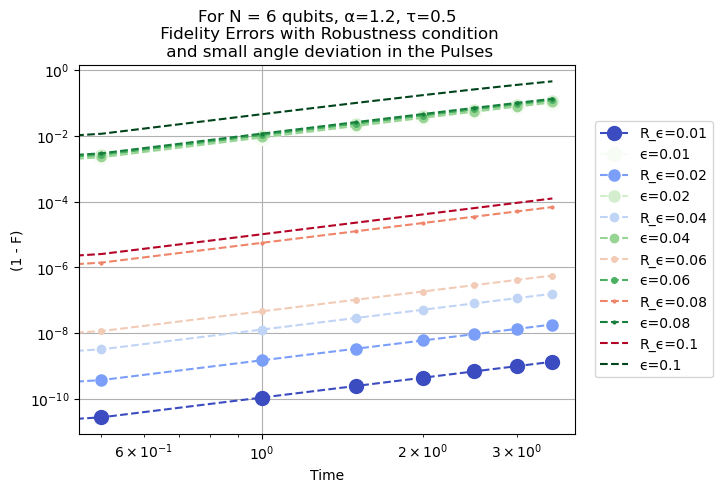

In [104]:
# Initial Script
## With double_avg on PulseRotational_Angle and rotational angle errors in Pulses
params['alpha_list'] = [1.2]
params['tau_list'] = [0.5]
max_index = 6
params['Wx'], params['Wy'], params['We'] = list(range(0, max_index, 1)), list(range(0, max_index, 1)), list(range(0, max_index, 1))
params['N'] = len(params['Wx'])
params['WF_Wx'], params['WF_We'] = WF_Generate(params, We = params['Wx']), WF_Generate(params, We = params['We'])
params['err_list'] = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
params['n'] = len(params['WF_Wx'][0])
n, N, r, op, pulses, psi_nm, R, alpha = initialVals(params)
params['R'], params['r'] = R, r

# Plotting (1-F) vs T
cls = 10
colors1 = plt.cm.coolwarm(np.linspace(0, 1, len(params['err_list'])))
colors2 = plt.cm.Greens(np.linspace(0, 1, len(params['err_list'])))

for alpha in params['alpha_list']:
    for tau in params['tau_list']:
        for i, err in enumerate(params['err_list']):
            params['err'], params['alpha'] = err, alpha
            num_list = np.linspace(-2*params['err'], 2*params['err'], 2*params['N'])
            params['deltaError_list'] = np.random.choice(num_list, params['N'], replace=False)
            psi_t, F, uOp, t = [], [], [], []
            params['tau'] = tau

            # With Double_Avg
            uOp, t = doubleAvg_RotErr(params)
            psi_t = [normalizeWF(u@psi_nm) for i,u in enumerate(uOp)]
            F = [1-np.power(np.abs(np.vdot(psi_nm, pt)), 2) for pt in psi_t]
            plt.plot(t, F, "--o", label = f"R_ϵ={params['err']}", ms=cls, color = colors1[i])

            # With only Rotational Errors in Pulses
            params['T'] = t[len(t)-1]+params['tau']
            params['pulses'] = WF_WIList(params, Wx = params['Wx'], Wy = params['Wy'], rotational_angle_err = True)
            uOp, _ = WPSeq_TimeEvolOp(params)
            psi_t = [normalizeWF(u@psi_nm) for i,u in enumerate(uOp)]
            F = [1-np.power(np.abs(np.vdot(psi_nm, pt)), 2) for pt in psi_t]
            plt.plot(t, F, "--o", label = f"ϵ={params['err']}", ms=cls, color = colors2[i])
            
            cls -=2
            plt.yscale("log")
            plt.xscale("log")
            plt.legend()
            plt.xlabel("Time")
            plt.ylabel("(1 - F)")
            plt.title(f"For N = {params['N']} qubits, α={params['alpha']}, τ={params['tau']}\n Fidelity Errors with Robustness condition\n and small angle deviation in the Pulses")
            plt.grid('on')
        plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
        plt.show()

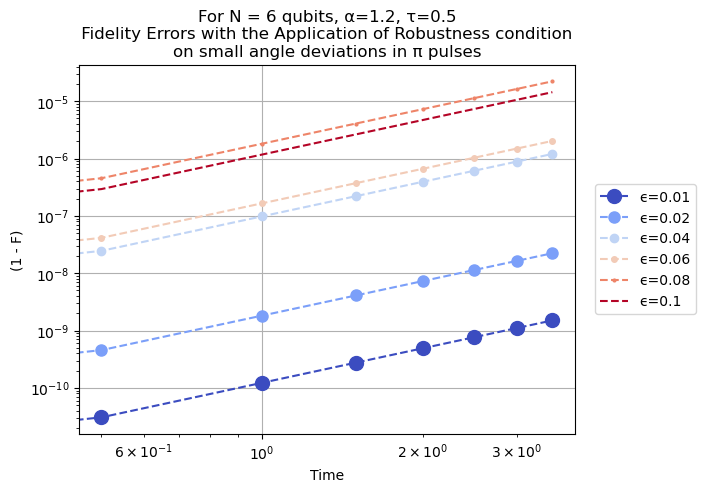

In [105]:
# Initial Script
## With double_avg on PulseRotational_Angle
params['alpha_list'] = [1.2]
params['tau_list'] = [0.5]
max_index = 6
params['Wx'], params['Wy'], params['We'] = list(range(0, max_index, 1)), list(range(0, max_index, 1)), list(range(0, max_index, 1))
params['N'] = len(params['Wx'])
params['WF_Wx'], params['WF_We'] = WF_Generate(params, We = params['Wx']), WF_Generate(params, We = params['We'])
params['err_list'] = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
params['n'] = len(params['WF_Wx'][0])
n, N, r, op, pulses, psi_nm, R, alpha = initialVals(params)
params['R'], params['r'] = R, r

# Plotting (1-F) vs T
colors1 = plt.cm.coolwarm(np.linspace(0, 1, len(params['err_list'])))
colors2 = plt.cm.Reds(np.linspace(1, 4, len(params['err_list'])))

for alpha in params['alpha_list']:
    for tau in params['tau_list']:
        cls = 10
        for i, err in enumerate(params['err_list']):
            params['err'], params['alpha'] = err, alpha
            num_list = np.linspace(-2*params['err'], 2*params['err'], 2*params['N'])
            params['deltaError_list'] = np.random.choice(num_list, params['N'], replace=False)
            psi_t, F, uOp, t = [], [], [], []
            params['tau'] = tau

            # With Double_Avg
            uOp, t = doubleAvg_RotErr(params)
            psi_t = [normalizeWF(u@psi_nm) for i,u in enumerate(uOp)]
            F = [1-np.power(np.abs(np.vdot(psi_nm, pt)), 2) for pt in psi_t]
            plt.plot(t, F, "--o", label = f"ϵ={params['err']}", ms=cls, color = colors1[i])
            cls -=2
            plt.yscale("log")
            plt.xscale("log")
            plt.legend()
            plt.xlabel("Time")
            plt.ylabel("(1 - F)")
            plt.title(f"For N = {params['N']} qubits, α={params['alpha']}, τ={params['tau']}\n Fidelity Errors with the Application of Robustness condition \non small angle deviations in π pulses")
            plt.grid('on')
        plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
        plt.show()

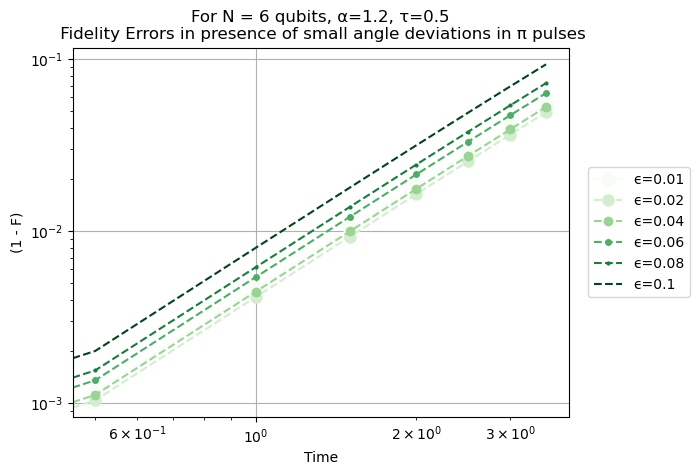

In [106]:
# Initial Script
## With errors in PulseRotational_Angle
params['alpha_list'] = [1.2]
params['tau_list'] = [0.5]
max_index = 6
params['Wx'], params['Wy'], params['We'] = list(range(0, max_index, 1)), list(range(0, max_index, 1)), list(range(0, max_index, 1))
params['N'] = len(params['Wx'])
params['WF_Wx'], params['WF_We'] = WF_Generate(params, We = params['Wx']), WF_Generate(params, We = params['We'])
params['err_list'] = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
params['n'] = len(params['WF_Wx'][0])
n, N, r, op, pulses, psi_nm, R, alpha = initialVals(params)
params['R'], params['r'] = R, r

# Plotting (1-F) vs T
cls = 10
colors2 = plt.cm.Greens(np.linspace(0, 1, len(params['err_list'])))

for alpha in params['alpha_list']:
    for tau in params['tau_list']:
        cls = 10
        for i, err in enumerate(params['err_list']):
            params['err'], params['alpha'] = err, alpha
            num_list = np.linspace(-2*params['err'], 2*params['err'], 2*params['N'])
            params['deltaError_list'] = np.random.choice(num_list, params['N'], replace=False)
            psi_t, F, uOp, t = [], [], [], []
            params['tau'] = tau

            # With only Rotational Errors in Pulses
            params['pulses'] = WF_WIList(params, Wx = params['Wx'], Wy = params['Wy'], rotational_angle_err = True)
            uOp, t = WPSeq_TimeEvolOp(params)
            # Hr = HRA_err(params)
            # uOp = [np.linalg.matrix_power(expm(-1j*params['tau']*Hr), i) for i, _ in enumerate(t) ]
            psi_t = [normalizeWF(u@psi_nm) for i,u in enumerate(uOp)]
            F = [1-np.power(np.abs(np.vdot(psi_nm, pt)), 2) for pt in psi_t]
            plt.plot(t, F, "--o", label = f"ϵ={params['err']}", ms=cls, color = colors2[i])
            
            cls -=2
            plt.yscale("log")
            plt.xscale("log")
            plt.legend()
            plt.xlabel("Time")
            plt.ylabel("(1 - F)")
            plt.title(f"For N = {params['N']} qubits, α={params['alpha']}, τ={params['tau']}\n Fidelity Errors in presence of small angle deviations in π pulses")
            plt.grid('on')
        plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
        plt.show()

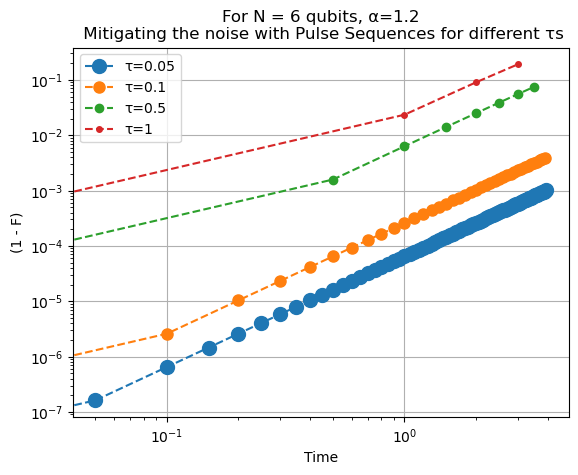

In [107]:
# Initial Script
## With no rotational angle errors in Pulses
params['alpha_list'] = [1.2]
params['tau_list'] = [0.5]
params['alpha'] = params['alpha_list'][0]
max_index = 6
params['Wx'], params['Wy'] = list(range(0, max_index, 1)), list(range(0, max_index, 1))
params['N'] = len(params['Wx'])
params['WF_Wx'] = WF_Generate(params, We = params['Wx'])
params['deltaError_list'] = [0 for _ in range(params['N'])]
params['pulses'] = WF_WIList(params, Wx = params['Wx'], Wy = params['Wy'], rotational_angle_err = False)
params['n'] = len(params['pulses'])
n, N, r, op, pulses, psi_nm, R, alpha = initialVals(params)
params['R'], params['r'] = R, r

# params['tau_list'] = [0.5, 1, 0.05, 0.1]
for alpha in params['alpha_list']:
    params['alpha'] = alpha
    cls = 10
    for tau in [0.05, 0.1, 0.5, 1]:
        psi_t, F, uOp, t = [], [], [], []
        params['tau'] = tau
        uOp, t = WPSeq_TimeEvolOp(params)
        psi_t = [normalizeWF(u@psi_nm) for i,u in enumerate(uOp)]
        F = [1-np.power(np.abs(np.vdot(psi_nm, pt)), 2) for pt in psi_t]
        plt.plot(t, F, "--o", label = f"τ={tau}", ms=cls)
        cls -=2
        plt.yscale("log")
        plt.xscale("log")
        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("(1 - F)")
        plt.title(f"For N = {params['N']} qubits, α={params['alpha']}\n Mitigating the noise with Pulse Sequences for different τs")
        plt.grid('on')
    plt.show()


In [43]:
# When the delta values for each qubits are close to each other,
# fidelity for all taus show the same patter.
# When they are further apart from each other (step difference less than
# order of -2), fidelity shows stark difference for different taus but 
# overlap for higher values of alpha.